<a href="https://colab.research.google.com/github/kartoone/cosc470/blob/main/keras/mnist-GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import keras
from keras import layers
from keras import ops

In [19]:
def reset_model(model):
    new_model = keras.models.clone_model(model)
    new_model.build(model.input_shape)  # Build the model with the same input shape
    return new_model

In [24]:
import numpy as np
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
print(np.shape(x_train))
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
x_train = expand_dims(x_train, axis=-1)
x_test = expand_dims(x_test, axis=-1)

#x_train = x_train.reshape(60000, (28,28,1)).astype("float32") / 255
#x_test = x_test.reshape(10000, (28,28,1)).astype("float32") / 255


(60000, 28, 28)


In [5]:
# example of loading the mnist dataset
from matplotlib import pyplot

# plot images from the training dataset
# n_samples must be a multiple of 5
def show_samples(samples, n_samples):
	for i in range(n_samples):
		# define subplot
		pyplot.subplot(5, 5, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		if len(samples[i]) == 2:
			pyplot.imshow(samples[0][i].reshape(28,28), cmap='gray_r')
		else:
			pyplot.imshow(samples[i], cmap='gray_r')
	pyplot.show()

In [25]:
import keras
from keras import layers

# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
	model = keras.Sequential(
     [
        layers.Input(shape=in_shape),
        layers.Conv2D(64, 3, strides=2),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Dropout(0.4),
        layers.Conv2D(64, 3, strides=2),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Dropout(0.4),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid'),
     ]
  )
	model = reset_model(model)
	# compile model
	opt = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['binary_accuracy'])
	return model

In [ ]:
model = define_discriminator()
# summarize the model
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 13, 13, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 13, 13, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 13, 13, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 6, 6, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           2,305 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 39,873 (155.75 KB)

 Trainable params: 39,873 (155.75 KB)

 Non-trainable params: 0 (0.00 B)

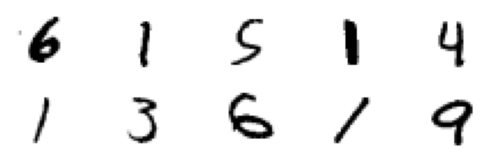

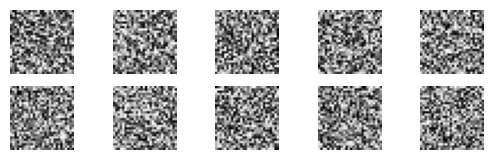

In [32]:
import numpy as np
import numpy.random as npr

# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = npr.randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = np.ones((n_samples, 1))
	return X, y

# generate n fake samples with class labels
def generate_fake_samples(n_samples):
	# generate uniform random numbers in [0,1]
	X = npr.rand(28 * 28 * n_samples)
	# reshape into a batch of grayscale images
	X = X.reshape((n_samples, 28, 28, 1))
	# generate 'fake' class labels (0)
	y = np.zeros((n_samples, 1))
	return X, y

real_X, real_y = generate_real_samples(x_train, 10)
fake_X, fake_y = generate_fake_samples(10)

show_samples(real_X, 10)
show_samples(fake_X, 10)

In [54]:
def train_discriminator(model, dataset, n_iter=100, n_batch=256):
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_iter):
		# get randomly selected 'real' samples
		X_real, y_real = generate_real_samples(dataset, half_batch)
		# update discriminator on real samples
		real = model.train_on_batch(X_real, y_real, return_dict=True)
		# generate 'fake' examples
		X_fake, y_fake = generate_fake_samples(half_batch)
		# update discriminator on fake samples
		fake = model.train_on_batch(X_fake, y_fake, return_dict=True)
	print(real)
	print(fake)
# define the discriminator model
model = define_discriminator()
# fit the model
train_discriminator(model, x_train)



{'binary_accuracy': array(0.935223, dtype=float32), 'loss': array(0.22596219, dtype=float32)}
{'binary_accuracy': array(0.9355469, dtype=float32), 'loss': array(0.2248645, dtype=float32)}


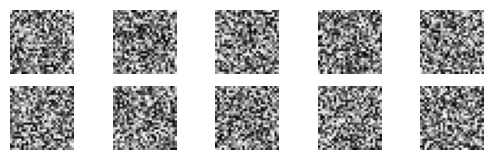

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
[0.00319495]
[0.00451026]
[0.00566544]
[0.00343382]
[0.00436277]
[0.00701362]
[0.00335865]
[0.0046195]
[0.00720568]
[0.00366043]


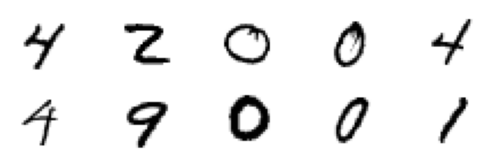

(10, 28, 28, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
[0.993389]
[0.988658]
[0.9057]
[0.9937676]
[0.9884216]
[0.9913845]
[0.99526817]
[0.9849727]
[0.9940591]
[0.9893713]


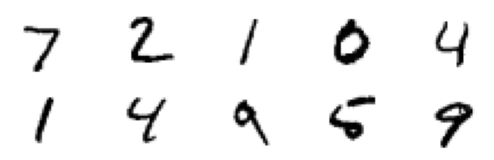

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[0.9852565]
[0.9755164]
[0.9857576]
[0.9965664]
[0.98638433]
[0.9922788]
[0.9833055]
[0.9923659]
[0.98619056]
[0.9973546]


In [30]:
X_fake, y_fake = generate_fake_samples(10)
X_real, y_real = generate_real_samples(x_train, 10)
show_samples(X_fake, 10)
results = model.predict(X_fake)
for i in range(10):
    print(results[i])

show_samples(X_real, 10)
print(X_real.shape)
results = model.predict(X_real)
for i in range(10):
    print(results[i])

show_samples(x_test, 10)
results = model.predict(x_test)
for i in range(10):
    print(results[i])

In [34]:
correct = 0
for i in range(10000):
    if results[i][0] > 0.5:
        correct += 1
print(correct)

10000


**The major problem at this point is if we input a "scribble" instead of random noise** then the discriminator is likely to classify it as a real image.

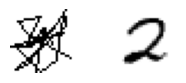

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
[[0.69818723]
 [0.9490691 ]]


In [71]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

file_list = ["scribble_28x28.png"]
X_test = []
for file in file_list:  # Load only the first 3 images
    image = Image.open(file).convert("L")  # Convert to grayscale
    image_array = 1-np.array(image, dtype=np.float32) / 255.0  # Normalize and convert to reverse grayscale
    image_array = np.expand_dims(image_array, axis=-1)  # Add channel dimension
    X_test.append(image_array)
X_test.append(x_test[35])
X_test = np.array(X_test)

show_samples(X_test, 2)

result = model.predict(X_test)
print(result)